In [3]:
import numpy as np
import matplotlib.pyplot as plt
import george

### 1. Generating some fake data (from a sinusoidal model) with error bars:

A sinusoidal model: $y = \mathrm{sin}(x)$

Period: $P = 2\pi = 6.28$, Amplitude: $1$, Error: $0.2$


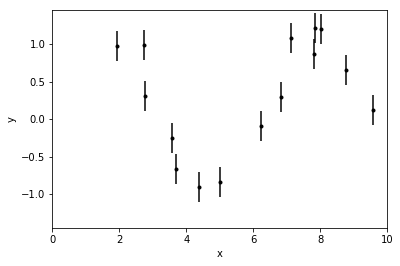

In [214]:
np.random.seed(1234)
x = 10 * np.sort(np.random.rand(15)) # 10 random points from 0 to 10.
yerr = 0.2 * np.ones_like(x)  #Error is 0.2
y = np.sin(x) + yerr * np.random.randn(len(x))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");

### 2. Choose the exponential suqared kernel.
$k\left(r^{2}\right)=\exp \left(-\frac{r^{2}}{2}\right)$

$ k_{i, j}=A \exp \left(-\frac{\left(x_{i}-x_{j}\right)^{2}}{2 l^{2}}\right)$. Long term rising trend.

$A$ > 0 is the amplitude of covariance, $l$ is the lengthscale of exponential decay, and $x_i− x_j$ is the separation between data points. 

If $l$ is large, two data points far apart in $x$ will be tightly correlated, and if small they will be loosely correlated. 

In [192]:
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize

def Exp2fit(constant_guess = 5., metric_guess = 6.):
#     constant_guess = 5. # Amplitude of squared-exponential decorrelation kernel
#     metric_guess = 6. # Decorrelation timescale SQUARED

    kexp2 = constant_guess * kernels.ExpSquaredKernel(metric=metric_guess)
    gp = george.GP(kexp2, fit_kernel= True)
    gp.compute(x,yerr)

    x_pred = np.linspace(0, 10, 500)
    pred, pred_var = gp.predict(y, x_pred, return_var=True)
    print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
    
    plt.figure()
    plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5, label = 'Fitted data')
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(x_pred, np.sin(x_pred), "--g", label = 'Original model')
    plt.xlim(0, 10)
    plt.ylim(-1.45, 1.45)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title('A = {}, Metric ={}'.format(constant_guess,metric_guess))
    plt.legend();
    

### 3. Test different initial parameters.

#### Use gp.compute(x, yerr)
:param yerr: (optional) ``(nsamples,)`` or scalar
    - The Gaussian uncertainties on the data points at coordinates
    ``x``. These values will be added in quadrature to the diagonal of
    the covariance matrix.

Initial ln-likelihood: -79.41
Initial ln-likelihood: -23.08
Initial ln-likelihood: -10.98
Initial ln-likelihood: -16.04
Initial ln-likelihood: -14.49
Initial ln-likelihood: -15.81


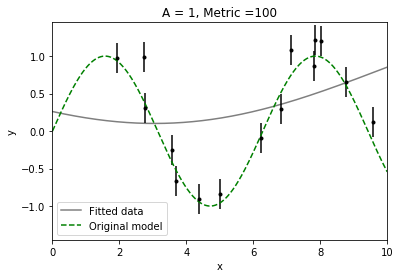

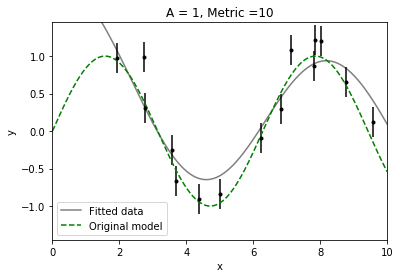

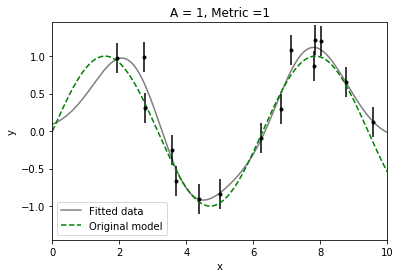

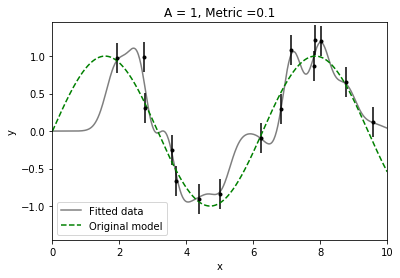

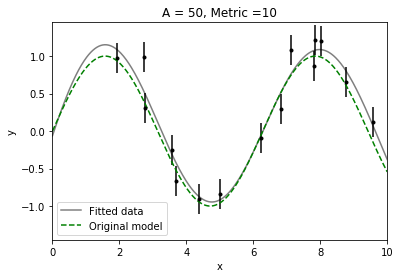

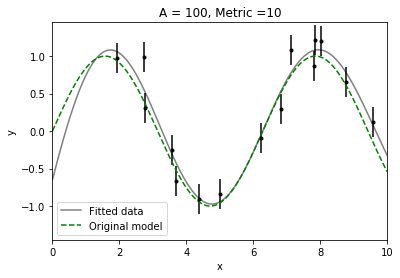

In [193]:
Exp2fit(1,100);Exp2fit(1,10);Exp2fit(1,1);Exp2fit(1,0.1);Exp2fit(50,10);
Exp2fit(100,10)

#### gp.compute(x, yerr) -> gp.compute(x)

Initial ln-likelihood: -197151516699.62
Initial ln-likelihood: -173553408737.39
Initial ln-likelihood: -3119994.08
Initial ln-likelihood: -35.40
Initial ln-likelihood: -136360266452.07
Initial ln-likelihood: -133051691824.17


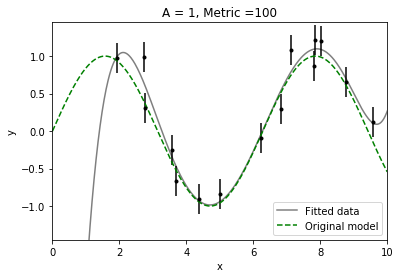

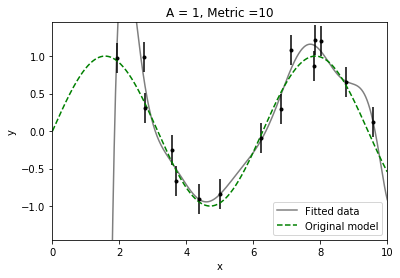

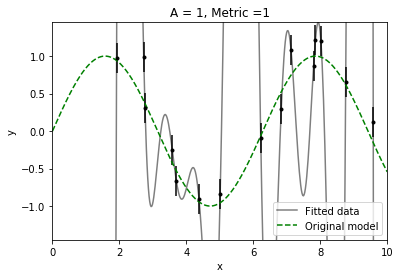

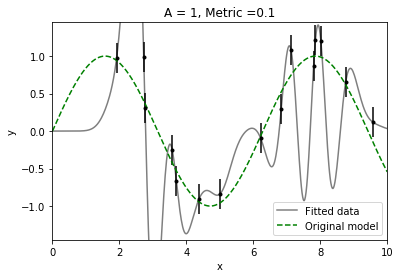

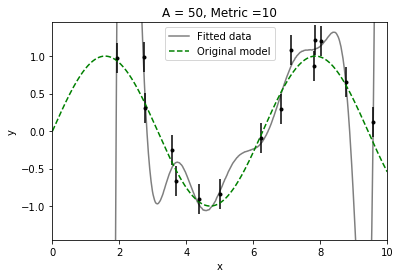

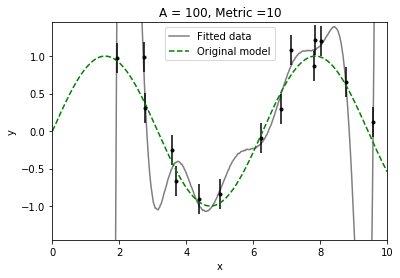

In [41]:
Exp2fit(1,100);Exp2fit(1,10);Exp2fit(1,1);Exp2fit(1,0.1);Exp2fit(50,10);
Exp2fit(100,10)

### 4. Minimization - fit for the maximum likelihood parameters:

In [176]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

def maxlik(constant_guess = 5., metric_guess = 6.):
#     constant_guess = 5. # Amplitude of squared-exponential decorrelation kernel
#     metric_guess = 6. # Decorrelation timescale SQUARED

    kexp2 = constant_guess * kernels.ExpSquaredKernel(metric=metric_guess)
    gp = george.GP(kexp2, fit_kernel= True)
    gp.compute(x,yerr)

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    print(result['x'])
    return result['x']

#### 4.1 Test minimization function:

In [208]:
# Different initial parameters:
maxlik(5,6); maxlik(1,10); maxlik(100,0.1); maxlik(100,100);maxlik(100,100000);

[-0.48730534  0.60407602]
[-0.48730646  0.60407403]
[-0.48730529  0.60407586]
[-0.48730533  0.60407543]
[-0.48730185  0.60407985]


In [209]:
print('The parameters in log scale right now are: ',gp.get_parameter_vector())

The parameters right now are:  [-0.48730185  0.60407985]


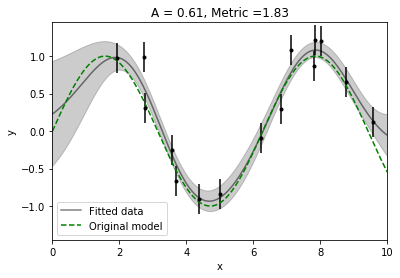

In [210]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)
plt.figure()
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5, label = 'Fitted data')
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g", label = 'Original model')
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.title('A = {:.2F}, Metric ={:.2F}'.format(np.exp(gp.get_parameter_vector()[0]),np.exp(gp.get_parameter_vector()[1])))
plt.legend();

#### 4.2 gp.compute(x,yerr):

In [142]:
constant_guess = 5 #ln(5) = 1.6094
metric_guess = 4   #ln(4) = 1.386
kexp2 = constant_guess * kernels.ExpSquaredKernel(metric=metric_guess)
gp = george.GP(kexp2, fit_kernel= True)
gp.compute(x,yerr)
print('Inital parameterts in log scale: \t \t{}'.format(gp.get_parameter_vector()))

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print('Maximum likelihood parameters in log scale: \t{}'.format(result['x']))

Inital parameterts: 	 	[1.60943791 1.38629436]
Maximum likelihood parameters: 	[-0.48730716  0.60407658]


#### 4.3 gp.compute(x):

Inital parameterts: 	 	[1.60943791 1.79175947]
Maximum likelihood parameters: 	[25.20722556  1.12211811]


/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


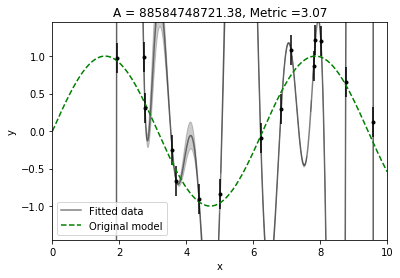

In [217]:
constant_guess = 5 #ln(5) = 1.6094
metric_guess = 6   #ln(4) = 1.386
kexp2 = constant_guess * kernels.ExpSquaredKernel(metric=metric_guess)
gp = george.GP(kexp2, fit_kernel= True)
gp.compute(x)
print('Inital parameterts: \t \t{}'.format(gp.get_parameter_vector()))

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print('Maximum likelihood parameters: \t{}'.format(result['x']))

#------------------------------------
#Plot the model
x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)
plt.figure()
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5, label = 'Fitted data')
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g", label = 'Original model')
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.title('A = {:.2F}, Metric ={:.2F}'.format(np.exp(gp.get_parameter_vector()[0]),np.exp(gp.get_parameter_vector()[1])))
plt.legend();

<font color='red'> Note: </font>It seems that the errors have to be input in the model.

### 5. larger data sets.

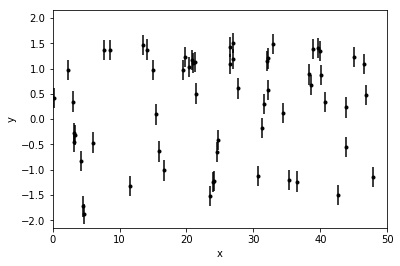

In [218]:
np.random.seed(1214)
x =  50* np.sort(np.random.rand(60)) # 60 random points
yerr = 0.2 * np.ones_like(x)  #Error is 0.2
y = 1.5* np.sin(x) + yerr * np.random.randn(len(x))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(0, 50)
plt.ylim(-2.15, 2.15)
plt.xlabel("x")
plt.ylabel("y");

In [160]:
def Exp2fit2(constant_guess = 5., metric_guess = 6.):
#     constant_guess = 5. # Amplitude of squared-exponential decorrelation kernel
#     metric_guess = 6. # Decorrelation timescale SQUARED

    kexp2 = constant_guess * kernels.ExpSquaredKernel(metric=metric_guess)
    gp = george.GP(kexp2, fit_kernel= True)
    gp.compute(x,yerr)

    x_pred = np.linspace(0, 50, 1500)
    pred, pred_var = gp.predict(y, x_pred, return_var=True)
    print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
    
    plt.figure()
    plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5, label = 'Fitted data')
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(x_pred, 1.5* np.sin(x_pred), "--g", label = 'Original model')
    #plt.xlim(0, 10)
    #plt.ylim(-1.45, 1.45)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title('A = {}, Metric ={}'.format(constant_guess,metric_guess))
    plt.legend();

Initial ln-likelihood: -536.80
Initial ln-likelihood: -686.19
Initial ln-likelihood: -54.14


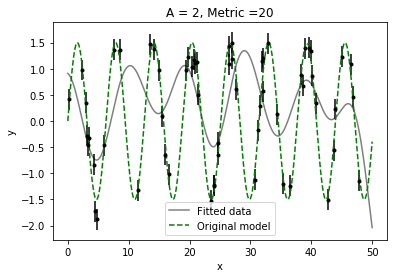

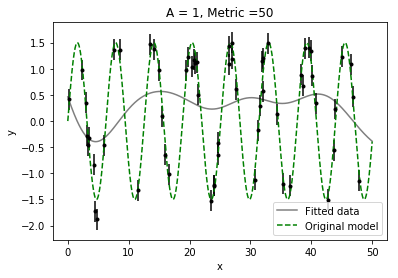

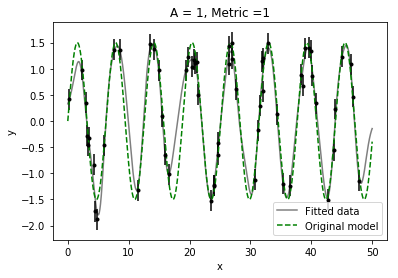

In [161]:
Exp2fit2(constant_guess= 2, metric_guess =20 ); Exp2fit2(1, 50); Exp2fit2(1, 1)

#### 5.1 Maximum likelihood parameters:

In [163]:
constant_guess = 5 #ln(5) = 1.6094
metric_guess = 10   #ln(4) = 1.386
kexp2 = constant_guess * kernels.ExpSquaredKernel(metric=metric_guess)
gp = george.GP(kexp2, fit_kernel= True)
gp.compute(x,yerr)
print('Inital parameterts: \t \t{}'.format(gp.get_parameter_vector()))
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print('Maximum likelihood parameters: \t{}'.format(result['x']))

Inital parameterts: 	 	[1.60943791 2.30258509]
Maximum likelihood parameters: 	[0.65878303 1.05862658]


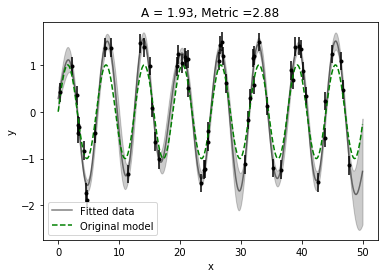

In [167]:
x_pred = np.linspace(0, 50, 1500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)
plt.figure()
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5, label = 'Fitted data')
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g", label = 'Original model')
#plt.xlim(0, 10)
#plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.title('A = {:.2F}, Metric ={:.2F}'.format(np.exp(gp.get_parameter_vector()[0]),np.exp(gp.get_parameter_vector()[1])))
plt.legend();

### 6. Exponetial-sine-squared kernel.

$$ k\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=\exp \left(-\Gamma \sin ^{2}\left[\frac{\pi}{P}\left|x_{i}-x_{j}\right|\right]\right) $$


In [219]:
def Expsinfit(constant_guess = 5., gamma_guess = 6., period = 6):
#     constant_guess = 5. # Amplitude of squared-exponential decorrelation kernel
#     metric_guess = 6. # Decorrelation timescale SQUARED

    kper = constant_guess * kernels.ExpSine2Kernel(gamma = gamma_guess, \
                                                   log_period= np.log(period))
    gp = george.GP(kper, fit_kernel= True)
    gp.compute(x,yerr)

    x_pred = np.linspace(0, 50, 1500)
    pred, pred_var = gp.predict(y, x_pred, return_var=True)
    print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
    
    plt.figure()
    plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5, label = 'Fitted data')
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(x_pred, np.sin(x_pred), "--g", label = 'Original model')
    #plt.xlim(0, 10)
    #plt.ylim(-1.45, 1.45)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title('A = {}, Metric ={}'.format(constant_guess,metric_guess))
    plt.legend();

In [ ]:
Expsinfit()

# Model fitting with correlated noise.